<a href="https://colab.research.google.com/github/cutemfc/retail_demand_forecast/blob/main/XGboost_Model_hyperparameter_tuning_revised.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Step1. Load the data and import libraries

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error

In [ ]:
# Import the dataset and mount google drive
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [ ]:
df_train_2014=pd.read_csv('/content/drive/MyDrive/retail_kaggle_data/df_train_2014.csv')
df_train_2014.head()

,store_nbr,item_nbr,date,id,unit_sales,onpromotion
0,24,105574,2013-01-02,18790.0,12.0,0.0
1,24,105574,2013-01-03,59692.0,1.0,0.0
2,24,105574,2013-01-04,99664.0,3.0,0.0
3,24,105574,2013-01-05,140805.0,4.0,0.0
4,24,105574,2013-01-06,182800.0,7.0,0.0


In [ ]:
df_train_2014.head()

,store_nbr,item_nbr,date,id,unit_sales,onpromotion
0,24,105574,2013-01-02,18790.0,12.0,0.0
1,24,105574,2013-01-03,59692.0,1.0,0.0
2,24,105574,2013-01-04,99664.0,3.0,0.0
3,24,105574,2013-01-05,140805.0,4.0,0.0
4,24,105574,2013-01-06,182800.0,7.0,0.0


In [ ]:
df_train_2014.shape

(9437752, 6)

In [ ]:
df_train_2014.dtypes

,0
store_nbr,int64
item_nbr,int64
date,object
id,float64
unit_sales,float64
onpromotion,float64


# Step 2: Data Preprocessing and Features Eingeerings

In [ ]:
# dateframe the date and Filter the data before 2014-04-01
df_train_2014['date']=pd.to_datetime(df_train_2014['date'])
# rename the df_train_2014 as df_train
df_train=df_train_2014.copy()




In [ ]:
df_train.shape

(9437752, 6)

In [ ]:
df_train.head()

,store_nbr,item_nbr,date,id,unit_sales,onpromotion
0,24,105574,2013-01-02,18790.0,12.0,0.0
1,24,105574,2013-01-03,59692.0,1.0,0.0
2,24,105574,2013-01-04,99664.0,3.0,0.0
3,24,105574,2013-01-05,140805.0,4.0,0.0
4,24,105574,2013-01-06,182800.0,7.0,0.0


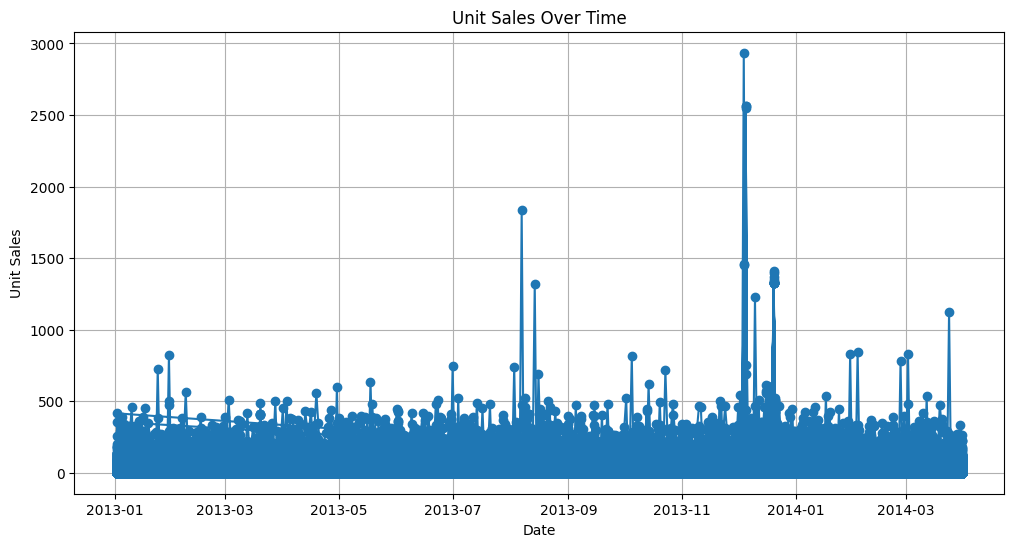

In [ ]:
# plot the sales unit and date line plot
plt.figure(figsize=(12,6))
plt.plot(df_train['date'],df_train['unit_sales'],marker='o',linestyle='-')
plt.title('Unit Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Unit Sales')
plt.grid(True)

In [ ]:
df_train.shape

(9437752, 6)

In [ ]:
df_train.shape

(9437752, 6)

In [ ]:
# Copy the df_train and rename it as df_filltered
df_filtered=df_train.copy()

In [ ]:
# Group by store_nbr and item_nbr
import pandas as pd

# Convert 'date' column to datetime format
df_filtered['date'] = pd.to_datetime(df_filtered['date'])

# Create an empty DataFrame to store the final result
df_filled = pd.DataFrame()

# Iterate through each store and item combination
for (store, item), group in df_filtered.groupby(['store_nbr', 'item_nbr']):
    # Get the minimum and maximum dates in the dataset to create a full date range
    min_date = group['date'].min()
    max_date = group['date'].max()
    #print(min_date.date(), max_date.date())

    # Create a full date range covering all days between the min and max dates
    full_date_range = pd.date_range(start=min_date, end=max_date, freq='D')

    # Set 'date' as index and sort by date
    group.set_index('date', inplace=True)
    group = group.sort_index()

    # Reindex to fill missing dates with 0 sales
    group = group.reindex(full_date_range, fill_value=0)

    # Keep track of the store and item number for each row
    group['store_nbr'] = store
    group['item_nbr'] = item

    # Ensure that missing sales values are filled with 0
    group['unit_sales'] = group['unit_sales'].fillna(0)

    # Append the group to the final DataFrame
    df_filled = pd.concat([df_filled, group])

# Reset the index to get 'date' back as a column
df_filled.reset_index(inplace=True)
df_filled.rename(columns={'index': 'date'}, inplace=True)

KeyboardInterrupt: 

In [ ]:
df_filled.head()

,date,store_nbr,item_nbr,id,unit_sales,onpromotion
0,2013-01-02,24,96995,NaN,0.0,NaN
1,2013-01-03,24,96995,NaN,0.0,NaN
2,2013-01-04,24,96995,NaN,0.0,NaN
3,2013-01-05,24,96995,NaN,0.0,NaN
4,2013-01-06,24,96995,NaN,0.0,NaN


In [ ]:
df_filled.shape

(9437752, 6)

In [ ]:
df_filled.isnull().sum()

,0
date,0
store_nbr,0
item_nbr,0
id,6690477
unit_sales,0
onpromotion,6690477


In [ ]:
# Only select the same  item_ids = [564533,838216,582865,364606] as classical
item_ids = [564533,838216,582865,364606]
df_train = df_filled[df_filled['item_nbr'].isin(item_ids)]

In [ ]:
df_train.head()

,date,store_nbr,item_nbr,id,unit_sales,onpromotion
129390,2013-01-02,24,364606,19063.0,92.0,0.0
129391,2013-01-03,24,364606,59960.0,88.0,0.0
129392,2013-01-04,24,364606,99924.0,85.0,0.0
129393,2013-01-05,24,364606,141069.0,92.0,0.0
129394,2013-01-06,24,364606,183066.0,80.0,0.0


In [ ]:
# Reset date as index
df_train.set_index('date', inplace=True)

In [ ]:
df_train.head()

,store_nbr,item_nbr,id,unit_sales,onpromotion
date,,,,,
2013-01-02,24,364606,19063.0,92.0,0.0
2013-01-03,24,364606,59960.0,88.0,0.0
2013-01-04,24,364606,99924.0,85.0,0.0
2013-01-05,24,364606,141069.0,92.0,0.0
2013-01-06,24,364606,183066.0,80.0,0.0


In [ ]:
df_train.shape

(9988, 5)

In [ ]:
# save the data in google googledrive
df_train.to_csv('/content/drive/MyDrive/retail_kaggle_data/df_train_revised.csv', index=True)

In [ ]:
# load the data from google drive
df_train=pd.read_csv('/content/drive/MyDrive/retail_kaggle_data/df_train_revised.csv')

In [ ]:
# check the missing values
df_train.isnull().sum()

,0
date,0
store_nbr,0
item_nbr,0
id,1278
unit_sales,0
onpromotion,1278


# Feature Eingeering
(1) Creating Lag features

(2) Creating Rolling statistics

(3) Adding Date-based Features


In [ ]:
# create lag features
df_train['lag_1'] = df_train['unit_sales'].shift(1)
df_train['lag_7'] = df_train['unit_sales'].shift(7)
df_train['lag_30'] = df_train['unit_sales'].shift(30)




In [ ]:
df_train.head()

,date,store_nbr,item_nbr,id,unit_sales,onpromotion,lag_1,lag_7,lag_30
0,2013-01-02,24,364606,19063.0,92.0,0.0,NaN,NaN,NaN
1,2013-01-03,24,364606,59960.0,88.0,0.0,92.0,NaN,NaN
2,2013-01-04,24,364606,99924.0,85.0,0.0,88.0,NaN,NaN
3,2013-01-05,24,364606,141069.0,92.0,0.0,85.0,NaN,NaN
4,2013-01-06,24,364606,183066.0,80.0,0.0,92.0,NaN,NaN


In [ ]:
# Creating Rolling Statistics
df_train['rolling_mean_7'] = df_train['unit_sales'].rolling(window=7).mean()
df_train['rolling_std_7'] = df_train['unit_sales'].rolling(window=7).std()
# Drop any NaN values afteer creating rolling features
df_train.dropna(inplace=True)



In [ ]:
df_train.head()

,date,store_nbr,item_nbr,id,unit_sales,onpromotion,lag_1,lag_7,lag_30,rolling_mean_7,rolling_std_7
30,2013-02-01,24,364606,1230253.0,87.0,0.0,68.0,51.0,92.0,77.000000,7.724420
31,2013-02-02,24,364606,1273982.0,110.0,0.0,87.0,75.0,88.0,82.000000,14.537308
32,2013-02-03,24,364606,1318242.0,103.0,0.0,110.0,88.0,85.0,84.142857,16.537116
33,2013-02-04,24,364606,1361309.0,87.0,0.0,103.0,73.0,92.0,86.142857,15.794815
34,2013-02-05,24,364606,1402686.0,98.0,0.0,87.0,71.0,80.0,90.000000,14.742230


In [ ]:
# check the missing values
df_train.isnull().sum()

,0
date,0
store_nbr,0
item_nbr,0
id,0
unit_sales,0
onpromotion,0
lag_1,0
lag_7,0
lag_30,0
rolling_mean_7,0


In [ ]:
# Create a index back to a datatimeindex
df_train['date']= pd.to_datetime(df_train['date'])
df_train.set_index('date', inplace=True)

In [ ]:
# Visualization the new featuress alongside the original sales
df_train[['unit_sales','rolling_mean_7','rolling_std_7']].plot(figsize=(12,6))
plt.title('Rolling Mean and Standard Deviation')
plt.xlabel('Date')
plt.ylabel('Unit Sales')
plt.show()

NameError: name 'df_train' is not defined

In [ ]:
# add time based Features
df_train['year'] = df_train.index.year
df_train['month'] = df_train.index.month
df_train['day_of_week'] = df_train.index.dayofweek
df_train['is_weekend'] = df_train['day_of_week'].apply(lambda x:1 if x>=5 else 0)

In [ ]:
df_train.head()

,store_nbr,item_nbr,id,unit_sales,onpromotion,lag_1,lag_7,lag_30,rolling_mean_7,rolling_std_7,year,month,day_of_week,is_weekend
date,,,,,,,,,,,,,,
2013-02-01,24,364606,1230253.0,87.0,0.0,68.0,51.0,92.0,77.000000,7.724420,2013,2,4,0
2013-02-02,24,364606,1273982.0,110.0,0.0,87.0,75.0,88.0,82.000000,14.537308,2013,2,5,1
2013-02-03,24,364606,1318242.0,103.0,0.0,110.0,88.0,85.0,84.142857,16.537116,2013,2,6,1
2013-02-04,24,364606,1361309.0,87.0,0.0,103.0,73.0,92.0,86.142857,15.794815,2013,2,0,0
2013-02-05,24,364606,1402686.0,98.0,0.0,87.0,71.0,80.0,90.000000,14.742230,2013,2,1,0


In [ ]:
df_train.shape

(8680, 14)

In [ ]:
# check the outleir
df_train.describe()


,store_nbr,item_nbr,id,unit_sales,onpromotion,lag_1,lag_7,lag_30,rolling_mean_7,rolling_std_7,year,month,day_of_week,is_weekend
count,8680.000000,8680.000000,8.680000e+03,8680.000000,8680.0,8680.000000,8680.000000,8680.000000,8680.000000,8680.000000,8680.000000,8680.000000,8680.000000,8680.000000
mean,32.242396,464638.599194,1.031813e+07,30.375691,0.0,30.183525,30.188710,30.044470,30.147449,11.886660,2013.204608,5.728687,3.012558,0.288134
std,7.409678,99969.234880,6.092118e+06,33.698917,0.0,33.675171,33.748381,33.987376,25.816990,19.278819,0.403438,3.595199,2.003270,0.452920
min,24.000000,364606.000000,1.924100e+04,1.000000,0.0,0.000000,0.000000,0.000000,1.714286,0.755929,2013.000000,1.000000,0.000000,0.000000
25%,27.000000,364606.000000,5.134630e+06,12.000000,0.0,12.000000,12.000000,12.000000,14.000000,5.219013,2013.000000,2.750000,1.000000,0.000000
50%,30.000000,564533.000000,1.015443e+07,21.000000,0.0,21.000000,21.000000,20.000000,21.142857,7.830040,2013.000000,5.000000,3.000000,0.000000
75%,35.000000,564533.000000,1.531129e+07,37.000000,0.0,37.000000,37.000000,37.000000,37.428571,13.696106,2013.000000,9.000000,5.000000,1.000000
max,51.000000,564533.000000,2.165556e+07,1394.000000,0.0,1394.000000,1394.000000,1394.000000,291.142857,494.049834,2014.000000,12.000000,6.000000,1.000000


# Unit sales are with extream outlier, try to deal with the outliers

In [ ]:
# Identify the outlier, Z>5
import scipy.stats as stats
z_scores = stats.zscore(df_train['unit_sales'])
outliers = df_train[z_scores > 5]
outliers.head()
outliers.shape

(18, 14)

In [ ]:
# Replace the outlier as rolling_mean_7
df_train.loc[outliers.index, 'unit_sales'] = df_train.loc[outliers.index, 'rolling_mean_7']
df_train.describe()

,store_nbr,item_nbr,id,unit_sales,onpromotion,lag_1,lag_7,lag_30,rolling_mean_7,rolling_std_7,year,month,day_of_week,is_weekend
count,8680.000000,8680.000000,8.680000e+03,8680.000000,8680.0,8680.000000,8680.000000,8680.000000,8680.000000,8680.000000,8680.000000,8680.000000,8680.000000,8680.000000
mean,32.242396,464638.599194,1.031813e+07,29.835862,0.0,30.183525,30.188710,30.044470,30.147449,11.886660,2013.204608,5.728687,3.012558,0.288134
std,7.409678,99969.234880,6.092118e+06,27.098205,0.0,33.675171,33.748381,33.987376,25.816990,19.278819,0.403438,3.595199,2.003270,0.452920
min,24.000000,364606.000000,1.924100e+04,1.000000,0.0,0.000000,0.000000,0.000000,1.714286,0.755929,2013.000000,1.000000,0.000000,0.000000
25%,27.000000,364606.000000,5.134630e+06,12.000000,0.0,12.000000,12.000000,12.000000,14.000000,5.219013,2013.000000,2.750000,1.000000,0.000000
50%,30.000000,564533.000000,1.015443e+07,21.000000,0.0,21.000000,21.000000,20.000000,21.142857,7.830040,2013.000000,5.000000,3.000000,0.000000
75%,35.000000,564533.000000,1.531129e+07,37.000000,0.0,37.000000,37.000000,37.000000,37.428571,13.696106,2013.000000,9.000000,5.000000,1.000000
max,51.000000,564533.000000,2.165556e+07,279.857143,0.0,1394.000000,1394.000000,1394.000000,291.142857,494.049834,2014.000000,12.000000,6.000000,1.000000


### We removed the outliers(Z>5) and substitued by rolling_mean_7

### Outliers will be analyzed, as they may be caused by festivals or holidays that lead to unusually high sales.



# Step 3. Split data, hyperameter and XGBoost model building and Model evaluations

# Split the data into Training and Testing data

In [ ]:
# Split form 2014-01-01 train and test
split_date = '2014-01-01'
train = df_train.loc[df_train.index< split_date]
test = df_train.loc[df_train.index >= split_date]
print("Train dataframe shape:",train.shape)
print("Test dataframe shape:",test.shape)


Train dataframe shape: (6904, 14)
Test dataframe shape: (1776, 14)


In [ ]:
# Define target and features
X=df_train.drop(columns=['unit_sales'],axis=1)
y=df_train['unit_sales']


In [ ]:
X.head()

,store_nbr,item_nbr,id,onpromotion,lag_1,lag_7,lag_30,rolling_mean_7,rolling_std_7,year,month,day_of_week,is_weekend
date,,,,,,,,,,,,,
2013-02-01,24,364606,1230253.0,0.0,68.0,51.0,92.0,77.000000,7.724420,2013,2,4,0
2013-02-02,24,364606,1273982.0,0.0,87.0,75.0,88.0,82.000000,14.537308,2013,2,5,1
2013-02-03,24,364606,1318242.0,0.0,110.0,88.0,85.0,84.142857,16.537116,2013,2,6,1
2013-02-04,24,364606,1361309.0,0.0,103.0,73.0,92.0,86.142857,15.794815,2013,2,0,0
2013-02-05,24,364606,1402686.0,0.0,87.0,71.0,80.0,90.000000,14.742230,2013,2,1,0


In [ ]:
X.index.min()
print(X.index.min())
X.index.max()
print(X.index.max())


2013-01-02 00:00:00
2014-03-31 00:00:00


# Set the Hyperameters to find the best parameters

In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import mean_squared_error


In [ ]:
# Define the XGBoost regressor
xgb_model = XGBRegressor()

In [ ]:
# Define the parameter grid, try 3 values for each parameter
param_grid ={
    'eta': [0.01, 0.1, 0.3],
    'max_depth':[3,5,7],
    'subsample':[0.7,0.8,1.0],   # decide the fraction of data for each boosting to avoid the overfitting
    'colsample_bytree':[0.7,0.8,1.0], # decide the fraction of features to avoid overfitting
    'n_estimators':[100,200,300]
}

# Time series split for cross validation
tscv=TimeSeriesSplit(n_splits=5)
# Randomized search with cross-validation
random_search=RandomizedSearchCV(estimator=xgb_model,
                          param_distributions=param_grid,
                          cv=tscv,
                          n_iter=10,
                          scoring='neg_mean_squared_error')
# Fit the model and search the best hyperparameters
random_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params= random_search.best_params_
print('Best hyperparameters:', best_params)


Best hyperparameters: {'subsample': 0.8, 'n_estimators': 100, 'max_depth': 5, 'eta': 0.1, 'colsample_bytree': 0.7}


In [ ]:
#eta is equal to learing rate

#Implementing XGBoost for Time-Series Forecasting

In [ ]:
# take the best hyperematers into the XGBoost model
best_params = {
    'n_estimators': 100,
    'max_depth': 5,
    'eta': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.7
}


In [ ]:
# Fit the model
xgboost_model = xgb.XGBRegressor(**best_params)
xgboost_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, device=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.1, eval_metric=None,
             feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

In [ ]:
# Make sure the column remain the same
# Get the column names from the original training data X
original_features = X.columns.tolist()
X_test=X_test[original_features]

In [ ]:
# Make the prediction on the test set
y_pred = xgboost_model.predict(X_test)

In [ ]:
print(y_pred[:5])

[48.52874  55.162163 73.67346  51.626007 45.701942]


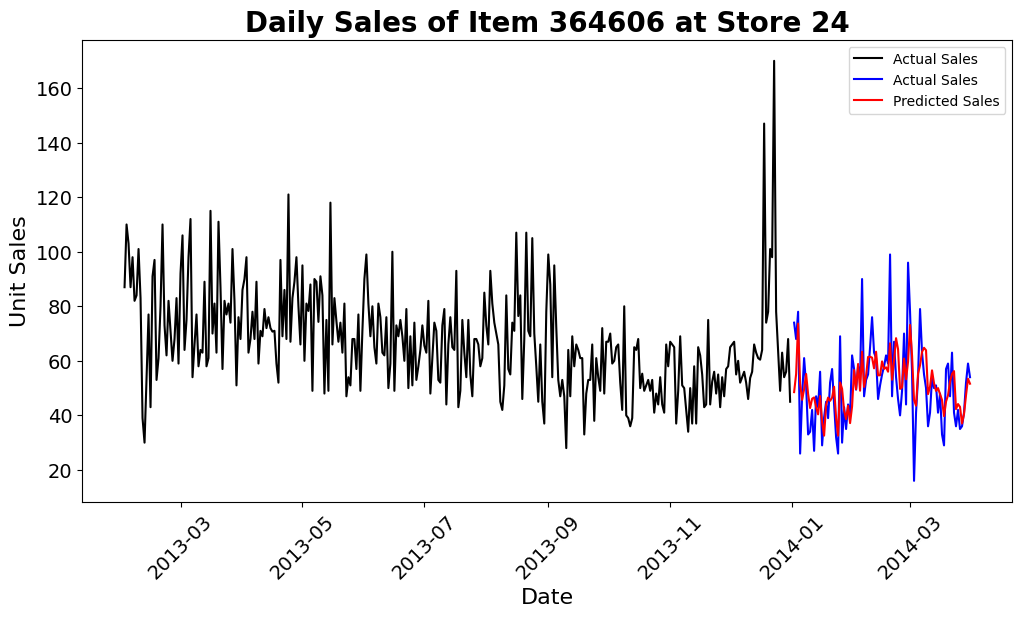

Item Number: 364606
Store Number: 24
Bias: 0.34402960567566204
RMAD: 8.356741230139571
RMSE: 11.340592514209536
MAPE: 18.725520765697535
R2: 0.4463968427438858


<Figure size 640x480 with 0 Axes>

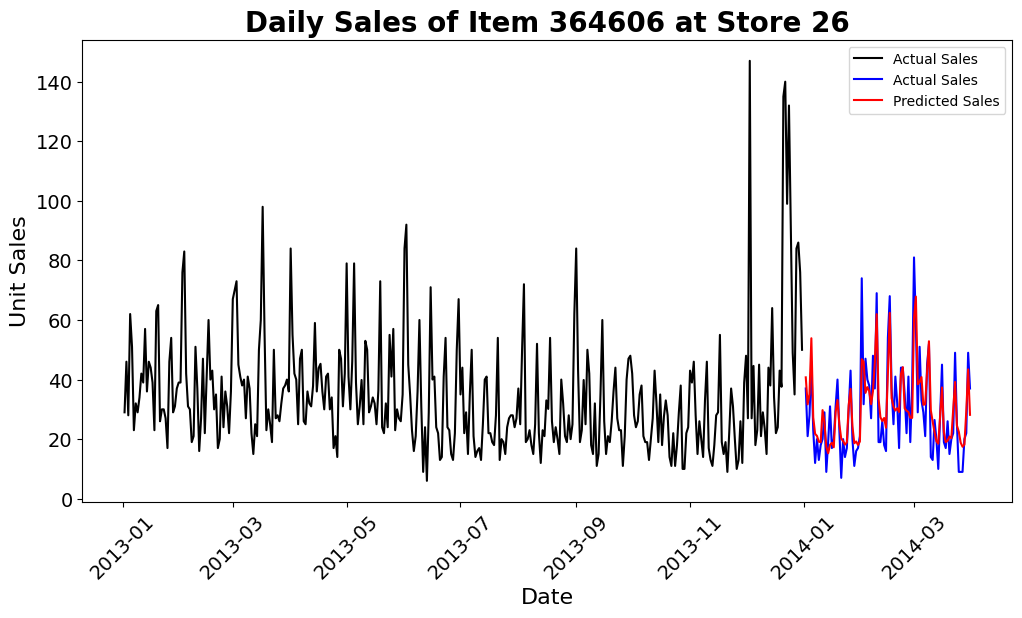

Item Number: 364606
Store Number: 26
Bias: 1.1619379646705394
RMAD: 6.676630243635102
RMSE: 8.280885598728672
MAPE: 30.874258450642085
R2: 0.7150588838328331


<Figure size 640x480 with 0 Axes>

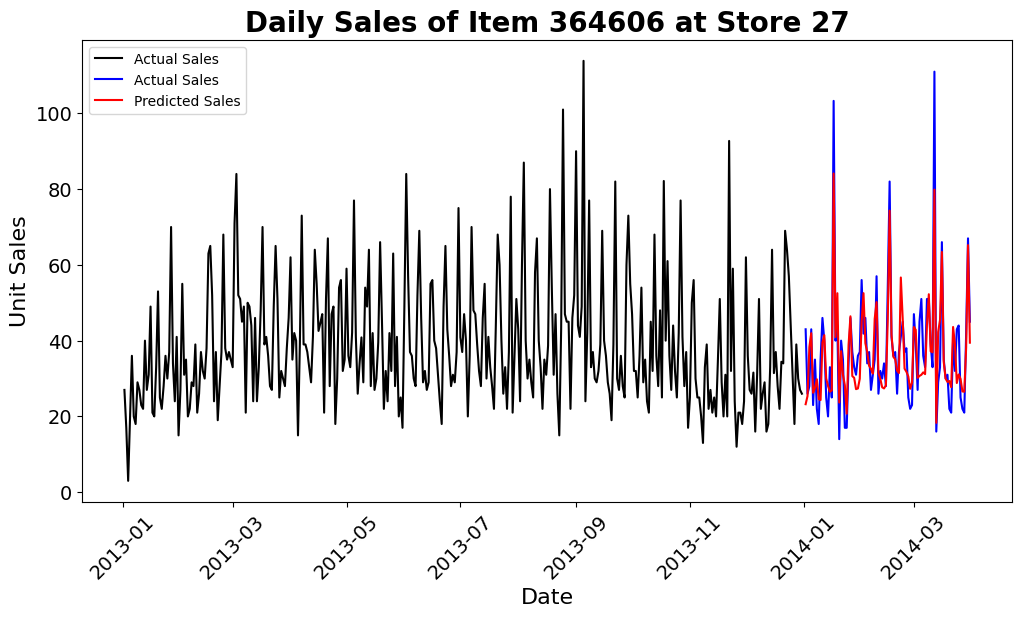

Item Number: 364606
Store Number: 27
Bias: -0.7643403318108181
RMAD: 6.152273325055216
RMSE: 8.040187937608163
MAPE: 17.862212830670053
R2: 0.739799148889899


<Figure size 640x480 with 0 Axes>

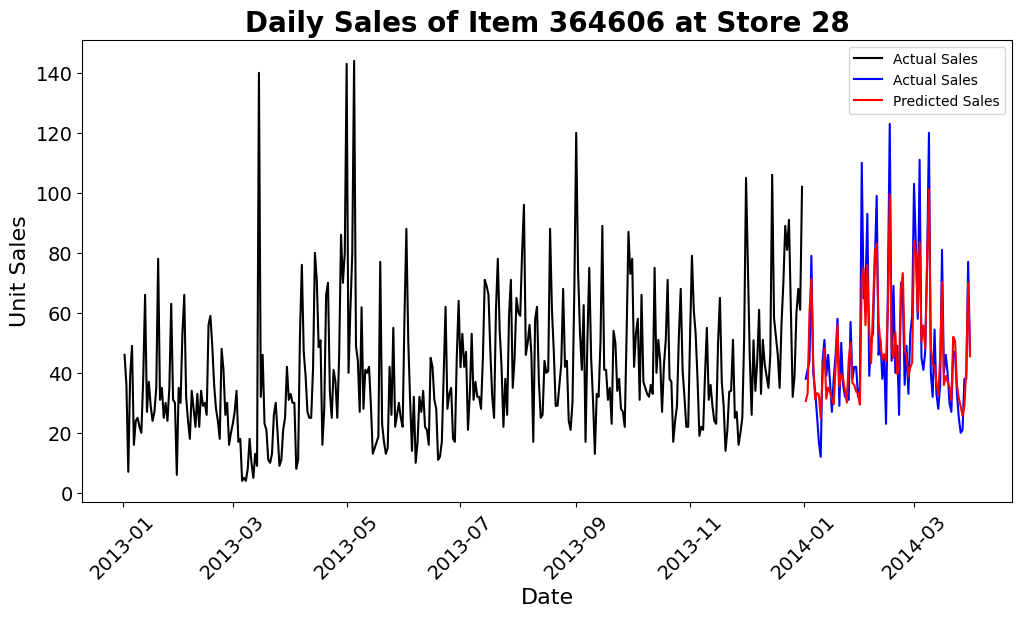

Item Number: 364606
Store Number: 28
Bias: -1.1086626466166343
RMAD: 8.365111640330111
RMSE: 10.614058568114308
MAPE: 19.443394526537045
R2: 0.7852813378483806


<Figure size 640x480 with 0 Axes>

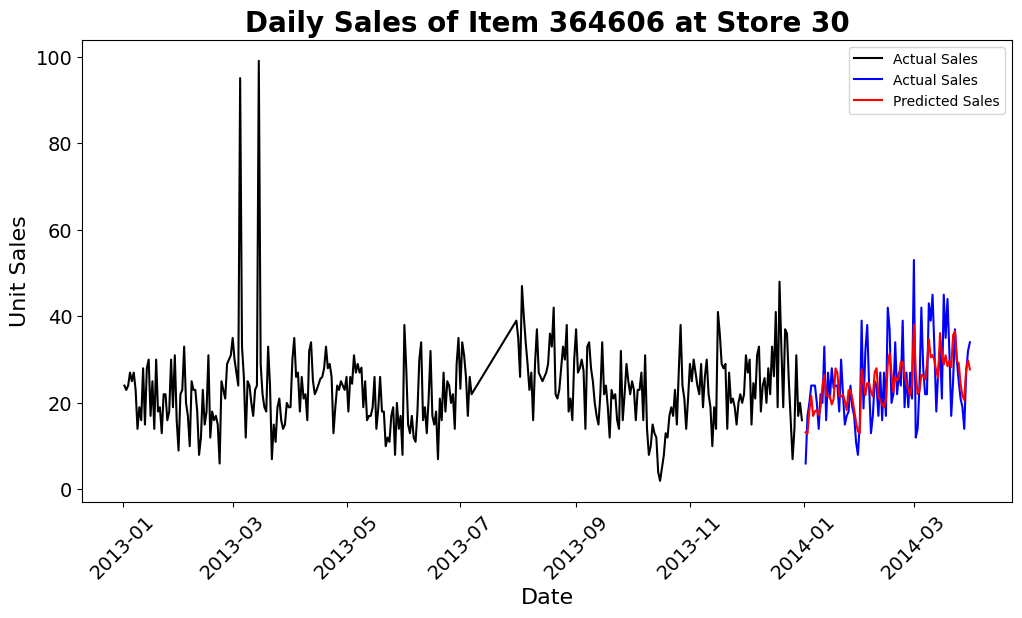

Item Number: 364606
Store Number: 30
Bias: -0.5447693544635803
RMAD: 5.522373741358088
RMSE: 6.841136260954053
MAPE: 24.474960435203837
R2: 0.44291951025317355


<Figure size 640x480 with 0 Axes>

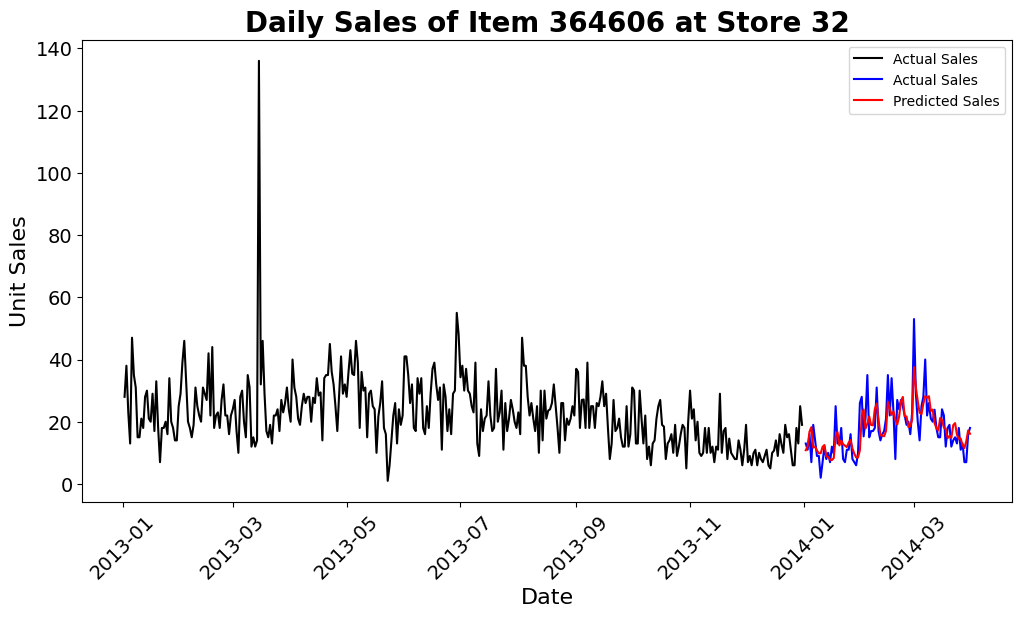

Item Number: 364606
Store Number: 32
Bias: 0.09151530074460931
RMAD: 4.119609727140031
RMSE: 5.423100241529991
MAPE: 30.67337722434116
R2: 0.585532195346972


<Figure size 640x480 with 0 Axes>

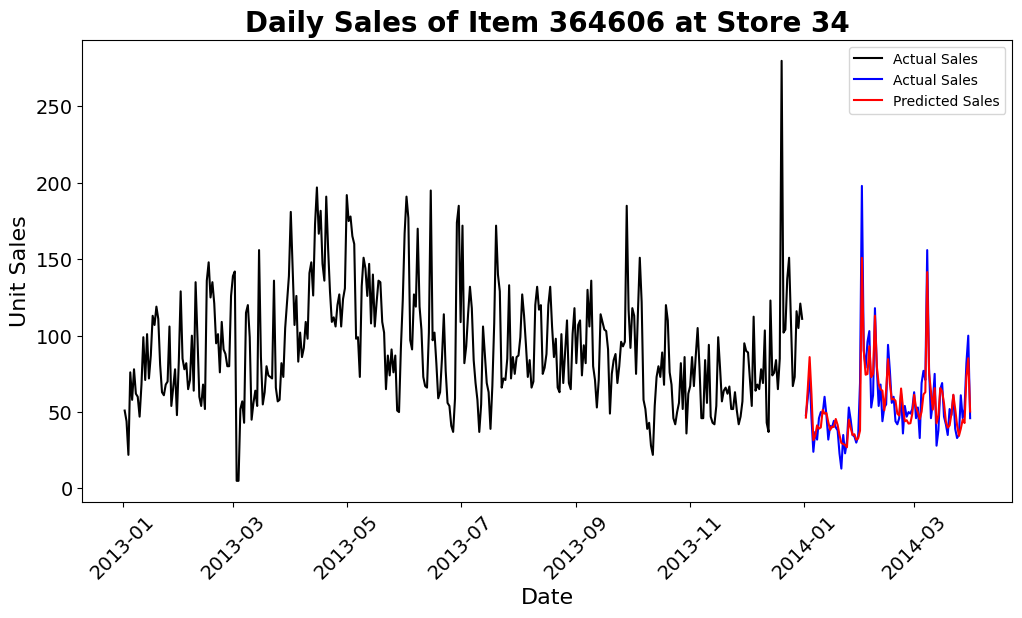

Item Number: 364606
Store Number: 34
Bias: -0.5247183749227999
RMAD: 8.151112925374871
RMSE: 11.013492695232772
MAPE: 16.73562079714226
R2: 0.8317727280421819


<Figure size 640x480 with 0 Axes>

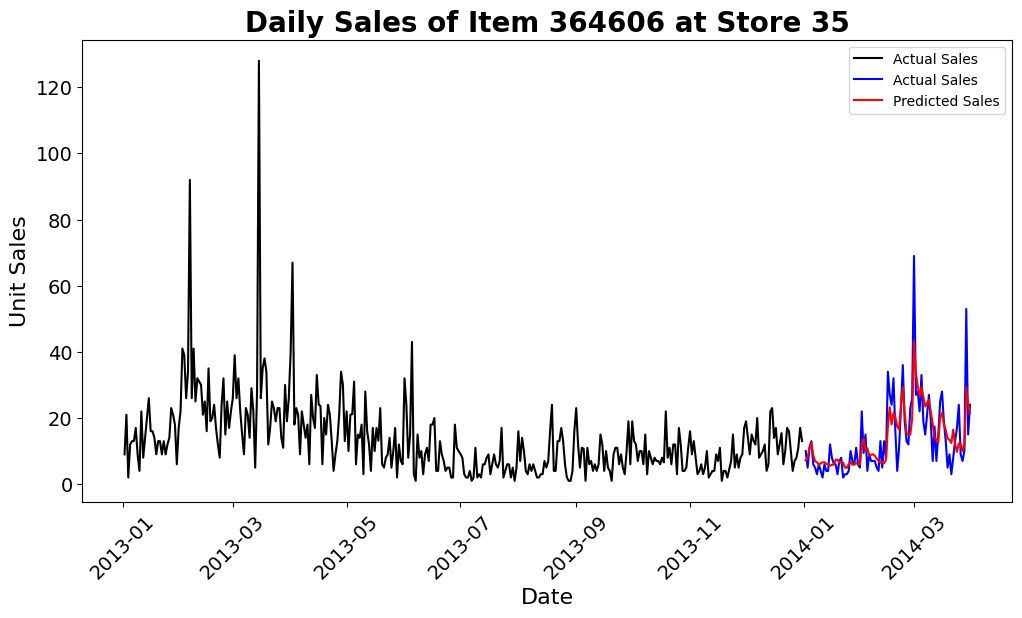

Item Number: 364606
Store Number: 35
Bias: -0.0469765823878599
RMAD: 4.564645955497534
RMSE: 6.401277172214786
MAPE: 49.11510999365848
R2: 0.6768782868365213


<Figure size 640x480 with 0 Axes>

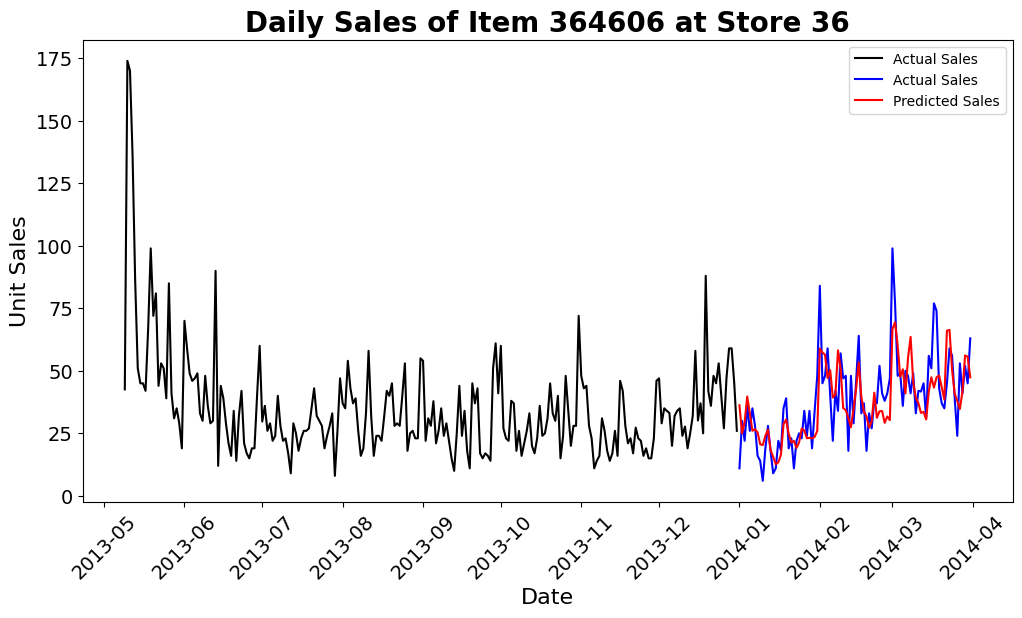

Item Number: 364606
Store Number: 36
Bias: -1.2255886335221549
RMAD: 9.396115265195332
RMSE: 11.861060481318162
MAPE: 29.89338451532172
R2: 0.5189867456558217


<Figure size 640x480 with 0 Axes>

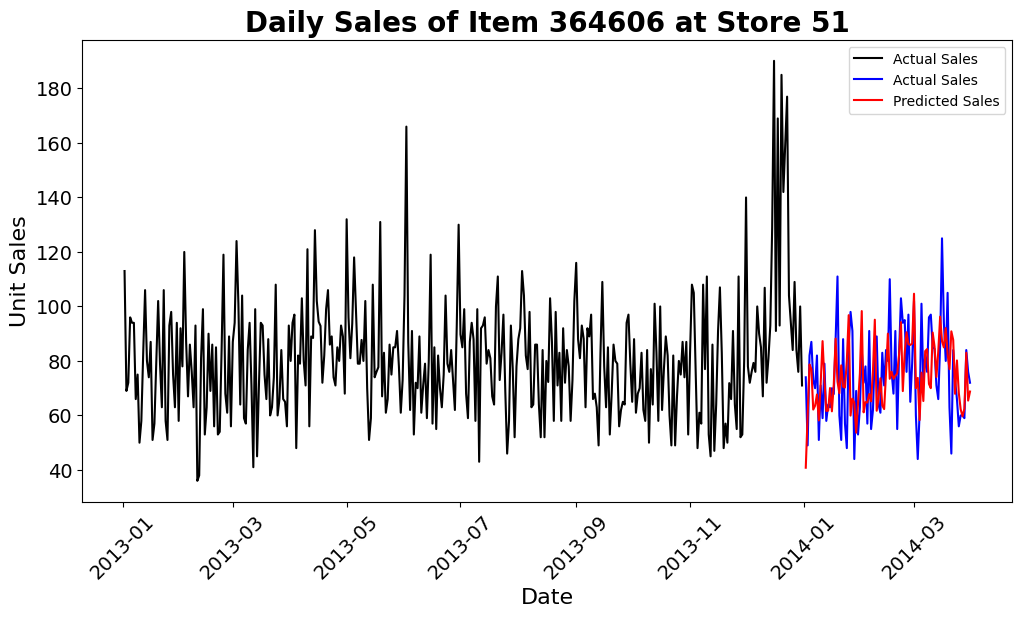

Item Number: 364606
Store Number: 51
Bias: -0.8951669879748007
RMAD: 13.170502125355826
RMSE: 16.726159746695885
MAPE: 18.326700380085498
R2: -0.0007935081967009872
Item Number: 564533
Store Number: 24
Bias: -0.35423403566951356
RMAD: 3.6471917457029486
RMSE: 4.593861137490051
MAPE: 27.05442419066404
R2: 0.22748793611987883
Item Number: 564533
Store Number: 26
Bias: 0.48972293997652844
RMAD: 4.328287925995754
RMSE: 5.367836673280368
MAPE: 36.811260812950394
R2: 0.4734838932865355
Item Number: 564533
Store Number: 27
Bias: 0.1572481935674494
RMAD: 3.0089831661868405
RMSE: 3.822388786236043
MAPE: 29.943384665931827
R2: 0.37042685215505855
Item Number: 564533
Store Number: 28
Bias: 0.2370036216009231
RMAD: 4.3287934089193545
RMSE: 5.2283606126626765
MAPE: 67.20610035641293
R2: 0.5133514046370311
Item Number: 564533
Store Number: 30
Bias: -0.0261186512477134
RMAD: 2.943569139722454
RMSE: 3.806918534221768
MAPE: 35.58036353576693
R2: 0.15900007522312976
Item Number: 564533
Store Number: 32


<Figure size 640x480 with 0 Axes>

In [ ]:
# Calculate metrics values and Plot the actual vs predicted values
rmad_values = []
bias_values = []
rmse_values = []
mape_values = []
r2_values = []
plot_paths = []
plot_count  = 0
split_date = '2014-01-01'



for (item_nbr, store_nbr), group in df_train.groupby(['item_nbr', 'store_nbr']):

   #group = group.groupby(['date']).sum()['unit_sales'].reset_index()
  group = group.reset_index()
  test_series = group[group['date'] >= split_date]
  if(len(test_series)>10):
    X_test = test_series.drop('unit_sales', axis=1)
    X_test = X_test.drop('date', axis=1)
    y_test = test_series['unit_sales']

    # Make predictions on the test set
    y_pred = xgboost_model.predict(X_test)
    #y_pred=best_model.predict(X_test)


    if plot_count<10:
      train_series = group[group['date'] < split_date]
      plt.figure(figsize=(12, 6))
      plt.plot(train_series['date'], train_series['unit_sales'].values, label='Actual Sales', color='black')
      plt.plot(test_series['date'], y_test.values, label='Actual Sales', color='blue')
      plt.plot(test_series['date'], y_pred, label='Predicted Sales', color='red')
      plt.title(f'Daily Sales of Item {item_nbr} at Store {store_nbr}', fontsize=20, fontweight='bold')
      plt.xlabel('Date', fontsize=16)
      plt.ylabel('Unit Sales', fontsize=16)
      plt.xticks(fontsize=14, rotation=45)
      plt.yticks(fontsize=14)
      file_path = f'XGBoost_forecast_store_{store_nbr}_item_{item_nbr}.png'
      plt.legend()
      plt.savefig(file_path)  # Saves the plot as a PNG file
      plt.show()
      plot_paths.append(file_path)
      plot_count = plot_count + 1
      plt.tight_layout()

    #Calculate metric values for XGBoost model
    # Bias calculation: mean of the residuals (y_pred - y_test)
    bias = np.mean(y_pred - y_test)
    bias_values.append(bias)
    # Root Mean Absolute Deviation (RMAD)
    rmad = np.mean(np.abs(y_pred - y_test))
    rmad_values.append(rmad)
    # Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    rmse_values.append(rmse)

    # Mean  abolute Percentage Error (MAPE)
    mape = np.mean(np.abs(y_pred - y_test) / y_test) * 100
    mape_values.append(mape)

    # R2 values
    r2 = r2_score(y_test, y_pred)
    r2_values.append(r2)
    # Print the data
    print(f"Item Number: {item_nbr}")
    print(f"Store Number: {store_nbr}")
    print(f"Bias: {bias}")
    print(f"RMAD: {rmad}")
    print(f"RMSE: {rmse}")
    print(f"MAPE: {mape}")
    print(f"R2: {r2}")

Feature importance is a great way to get a general idea about which features the model is relying on most to make the prediction.

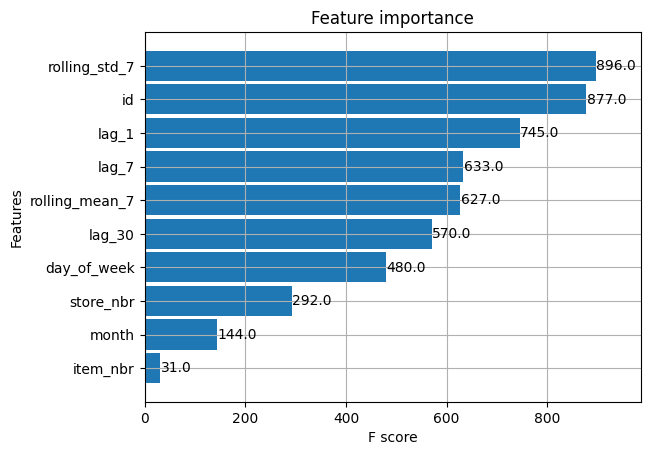

In [ ]:
# Feature Importance
plot_importance(best_model, height=0.9);

#Step 4: Evaluation comparisons
Each item and store has differnt

# How do we save the model

In [ ]:
import pickle
# define the path where are going to save the model
model_path='/content/drive/MyDrive/models/xgboost_model_revised.pkl'

# saving  xgboost_model model
with open(model_path, 'wb') as file:
    pickle.dump(xgboost_model, file)
print(f"Model saved as pickle file at:{model_path}")


Model saved as pickle file at:/content/drive/MyDrive/models/xgboost_model_revised.pkl


In [ ]:
# open the
with open(model_path, 'rb') as file:
    loaded_model = pickle.load(file)

In [ ]:
y_pred=loaded_model.predict(X_test)

In [ ]:
print("R2:",r2_score(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))

R2: 0.2681720818189578
MSE: 38.311796488288444
